In [42]:
# import functions from my_functions.py file
import sys
sys.path.append('/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start')
from my_functions import *

In [43]:
#-- Select the variable of interest
variable = "PW"

In [44]:
#-- Condition if Precac; Load segmentation relation file
num_int_per_day = 48
if variable == "Precac":
    df = loadRelTable()
    num_df_files = len(df['path_dyamond'])
    # num_df_files = 192 ### For testing

In [45]:
#-- Condition if not Precac; Search for files containing the desired characters
if not variable == "Precac":
    matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
    sorted_files = sorted(matching_files)
    # sorted_files = sorted_files[:192] ### For testing

In [46]:
#-- Initialize lists containing spatial mean over time and the times
data_list = [] 
timestamp_list = []

In [47]:
#-- Iterate through the timestamps and populate the arrays with a progress bar

from tqdm import tqdm

if not variable == "Precac":
    
    for i, file in tqdm(enumerate(sorted_files), total=len(sorted_files), desc='Processing'):

        # Access data
        data = xr.open_dataset(file)
        variable_data = data[variable]
        
        # Calculate spatial mean
        mean_lonlat = variable_data.mean(dim=['lon', 'lat'])
        mean_lonlat_value = mean_lonlat.values[0]

        # Getting timestamp
        start_marker = "DYAMOND_9216x4608x74_7.5s_4km_4608_"
        end_marker = f".{variable}.2D.nc"

        start_index = file.index(start_marker) + len(start_marker)
        end_index = file.index(end_marker)

        time_stamp = file[start_index:end_index]

        # Append to lists
        data_list.append(mean_lonlat_value)
        timestamp_list.append(time_stamp)
        
        # Delete data and remove from memory
        del data
        del mean_lonlat
        del mean_lonlat_value
        del variable_data
        gc.collect
        
else:
    
    for seg_index in tqdm(range(num_df_files - 1), desc='Processing'):
        
        # Handling edge case: making data the same for 0 and 1 index
        if seg_index == 0:
                seg_index = 1

        # Load data
        prec = loadPrec(seg_index,df)
        prec_filename = loadPrecacFilename(seg_index, df)
        time_stamp = prec_filename[119:129]

        # Replace negative values with NaN
        variable_data = xr.where(prec < 0, np.nan, prec)
        
        # Calculate spatial mean

        mean_lonlat = variable_data.mean(dim=['lon', 'lat'])
        mean_lonlat_value = mean_lonlat.item()  # Convert scalar to a Python float
    
        
        # Append to lists
        data_list.append(mean_lonlat_value)
        timestamp_list.append(time_stamp)

        # Delete data and remove from memory
        del prec
        del prec_filename
        del variable_data
        gc.collect
        

# Convert lists to arrays
data = np.array(data_list)
timestamps_array = np.array(timestamp_list)

Processing: 100%|██████████| 1087/1087 [00:07<00:00, 148.17it/s]


In [48]:
testdata = xr.open_dataset(file)
testdata

<xarray.Dataset>
Dimensions:  (lat: 518, lon: 896, time: 1)
Coordinates:
  * lat      (lat) float32 0.01931 0.05794 0.09657 0.1352 ... 19.91 19.95 19.99
  * lon      (lon) float32 130.0 130.1 130.1 130.1 ... 164.9 164.9 164.9 165.0
  * time     (time) float32 254.0
Data variables:
    PW       (time, lat, lon) float32 ...
Attributes:
    history:  Tue May 30 20:03:10 2023: ncks -O -d lon,130.,165. -d lat,0.,20...
    NCO:      netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, C...

# Data Plot

In [49]:
name_dict = {"OM500":"Pressure velocity at 500 mb", "T2mm":"2-m temperature", "OM850":"Pressure velocity at 850 mb", "Precac":"Surface Accum Precip.", "PW":"Precipitable Water", "CWP":"Cloud Water Path", "U10m":"10-m zonal wind", "RH500":"Relative Humidity 500mb", "PSFC":"P at the surface","V10m":"10-m meridional wind","SHF":"Sensible Heat Flux", "LHF":"Latent Heat Flux"}
unit_dict = {"OM500":"Pa/s","T2mm":"K", "OM850":"Pa/s","Precac":"mm", "PW":"kg/m²", "CWP":"kg/m²", "U10m":"m/s", "RH500":"", "PSFC":"mbar", "V10m":"m/s","SHF":"W/m²", "LHF":"W/m²"}

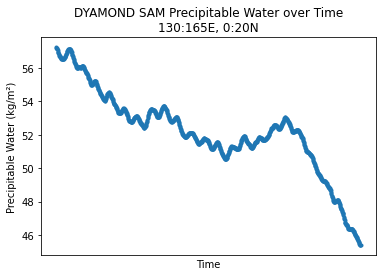

In [50]:
#-- plotting
var_name = name_dict.get(variable)
var_unit = unit_dict.get(variable)


# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
ax.plot(timestamps_array, data, marker='.', linestyle='none')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM {var_name} over Time\n130:165E, 0:20N')


plt.xticks([])

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_timeseries_test1.png')
plt.savefig(save_path)
data_img_path = save_path


plt.show()

### Shaded Data Plot

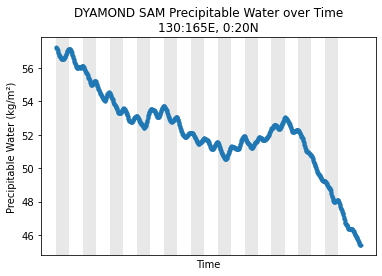

In [51]:
var_name = name_dict.get(variable)
var_unit = unit_dict.get(variable)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
ax.plot(timestamps_array, data, marker='.', linestyle='none')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM {var_name} over Time\n130:165E, 0:20N')

# Determine the number of shading blocks
num_blocks = len(data) // num_int_per_day

# Define the light grey and white shading colors
grey_shade_color = 'lightgrey'
white_shade_color = 'white'

# Iterate over the shading blocks
for i in range(num_blocks):
    # Calculate the start and end indices for each block
    start_index = i * num_int_per_day
    end_index = (i + 1) * num_int_per_day

    # Alternate between shading colors
    if i % 2 == 0:
        shade_color = grey_shade_color
    else:
        shade_color = white_shade_color

    # Add the shading using axvspan()
    ax.axvspan(timestamps_array[start_index], timestamps_array[end_index - 1], facecolor=shade_color, alpha=0.5)

plt.xticks([])

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_timeseriesSHADED_test1.png')
plt.savefig(save_path)
dataSHADED_img_path = save_path

plt.show()

### Labeled

### Subset of Shaded Data Plot

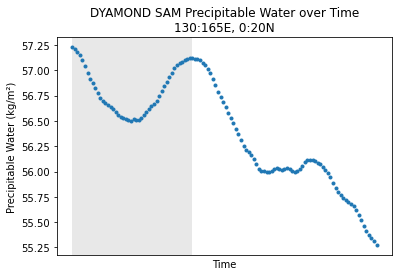

In [52]:
var_name = name_dict.get(variable)
var_unit = unit_dict.get(variable)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
ax.plot(timestamps_array[0:120], data[0:120], marker='.', linestyle='none')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM {var_name} over Time\n130:165E, 0:20N')

# Determine the number of shading blocks
num_blocks = len(data[0:120]) // num_int_per_day

# Define the light grey and white shading colors
grey_shade_color = 'lightgrey'
white_shade_color = 'white'

# Iterate over the shading blocks
for i in range(num_blocks):
    # Calculate the start and end indices for each block
    start_index = i * num_int_per_day
    end_index = (i + 1) * num_int_per_day

    # Alternate between shading colors
    if i % 2 == 0:
        shade_color = grey_shade_color
    else:
        shade_color = white_shade_color

    # Add the shading using axvspan()
    ax.axvspan(timestamps_array[start_index], timestamps_array[end_index - 1], facecolor=shade_color, alpha=0.5)

plt.xticks([])

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_timeseriesSHADEDSUBSET_test1.png')
plt.savefig(save_path)
dataSUBSET_img_path = save_path

plt.show()

### Log Data Plot

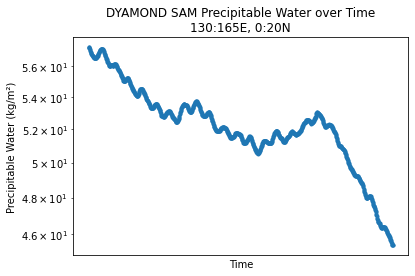

In [53]:
#-- plotting

var_name = name_dict.get(variable)
var_unit = unit_dict.get(variable)


# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
ax.plot(timestamps_array, data, marker='.', linestyle='none')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM {var_name} over Time\n130:165E, 0:20N')


# Set the y-axis scale to logarithmic
ax.set_yscale('log')

plt.xticks([])

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_timeseriesLOG_test1.png')
plt.savefig(save_path)
dataLOG_img_path = save_path


plt.show()

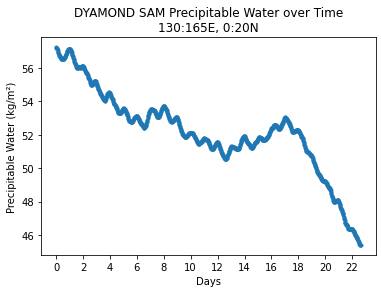

In [54]:
timestamps_dict = {}
for i in range(len(timestamps_array)):
    day_number = i // num_int_per_day
    if day_number not in timestamps_dict:
        timestamps_dict[day_number] = i

# Calculate the step size to evenly spread the tick labels
step = max(1, len(timestamps_dict) // 10)

# Select every 'step' tick label
selected_ticks = list(timestamps_dict.keys())[::step]

# Set x-axis tick positions
xticks = [timestamps_dict[tick] for tick in selected_ticks]

# Set x-axis tick labels
xlabels = selected_ticks

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data with correct x-coordinates
ax.plot(range(len(data)), data, marker='.', linestyle='none')

# Set the x-axis tick positions and labels
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

# Set the remaining plot properties
ax.set_xlabel('Days')
ax.set_ylabel(f'{var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM {var_name} over Time\n130:165E, 0:20N')

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_timeseriesLABELED_test1.png')
plt.savefig(save_path)
dataLABELED_img_path = save_path

plt.show()

### Labeled Log Data Plot

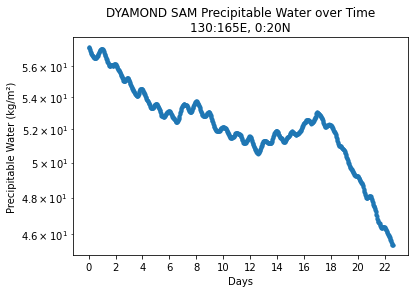

In [55]:
timestamps_dict = {}
for i in range(len(timestamps_array)):
    day_number = i // num_int_per_day
    if day_number not in timestamps_dict:
        timestamps_dict[day_number] = i

# Calculate the step size to evenly spread the tick labels
step = max(1, len(timestamps_dict) // 10)

# Select every 'step' tick label
selected_ticks = list(timestamps_dict.keys())[::step]

# Set x-axis tick positions
xticks = [timestamps_dict[tick] for tick in selected_ticks]

# Set x-axis tick labels
xlabels = selected_ticks

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data with correct x-coordinates
ax.plot(range(len(data)), data, marker='.', linestyle='none')

# Set the y-axis scale to logarithmic
ax.set_yscale('log')

# Set the x-axis tick positions and labels
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

# Set the remaining plot properties
ax.set_xlabel('Days')
ax.set_ylabel(f'{var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM {var_name} over Time\n130:165E, 0:20N')

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_timeseriesLABELEDLOG_test1.png')
plt.savefig(save_path)
dataLABELEDLOG_img_path = save_path

plt.show()

# Convolution
* Question on which mode I should use.
I assumed mode='same'

In [56]:
#-- Defining kernel
   
# Array of length num_int_per_day full of ones then divded by num_int_per_day
# we divide by num_int_per_day to normalize
kernel = np.ones(num_int_per_day) / num_int_per_day

In [57]:
#-- Making convolution

convolved_data = np.convolve(data, kernel, mode='same')

convolved_data = convolved_data[12:-12]
timestamps_array = timestamps_array[12:-12]

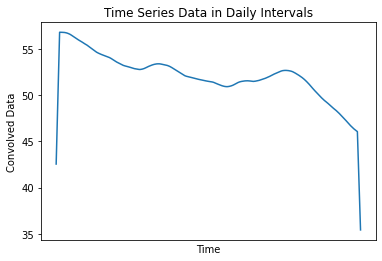

In [58]:
#-- Plot

# Create a figure and axes
fig, ax = plt.subplots()
plt.plot(convolved_data)
ax.set_xlabel('Time')
plt.ylabel('Convolved Data')
plt.title('Time Series Data in Daily Intervals')

plt.xticks([])
# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_convolve_test1.png')
plt.savefig(save_path)
conv_img_path = save_path

plt.show()

### Log Convolution Plot

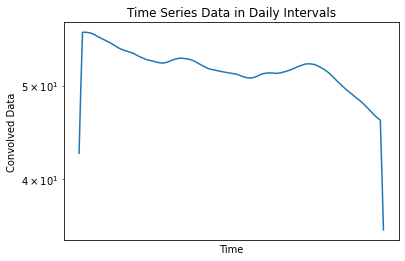

In [59]:
#-- Plot

# Create a figure and axes
fig, ax = plt.subplots()
plt.plot(convolved_data)
ax.set_xlabel('Time')
plt.ylabel('Convolved Data')
plt.title('Time Series Data in Daily Intervals')

# Set the y-axis scale to logarithmic
ax.set_yscale('log')

plt.xticks([])
# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_convolveLOG_test1.png')
plt.savefig(save_path)
convLOG_img_path = save_path

plt.show()

### Labeled

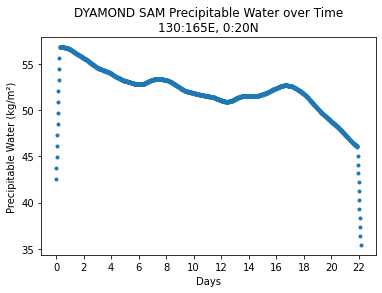

In [60]:
timestamps_dict = {}
for i in range(len(timestamps_array)):
    day_number = i // num_int_per_day
    if day_number not in timestamps_dict:
        timestamps_dict[day_number] = i

# Calculate the step size to evenly spread the tick labels
step = max(1, len(timestamps_dict) // 10)

# Select every 'step' tick label
selected_ticks = list(timestamps_dict.keys())[::step]

# Set x-axis tick positions
xticks = [timestamps_dict[tick] for tick in selected_ticks]

# Set x-axis tick labels
xlabels = selected_ticks

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data with correct x-coordinates
ax.plot(range(len(convolved_data)), convolved_data, marker='.', linestyle='none')

# Set the x-axis tick positions and labels
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

# Set the remaining plot properties
ax.set_xlabel('Days')
ax.set_ylabel(f'{var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM {var_name} over Time\n130:165E, 0:20N')

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_convolveLABELED_test1.png')
plt.savefig(save_path)
convLABELED_img_path = save_path

plt.show()

### Labeled Log Conv Plot

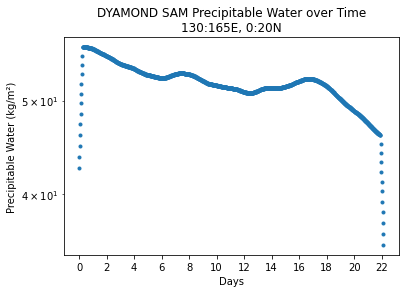

In [61]:
timestamps_dict = {}
for i in range(len(timestamps_array)):
    day_number = i // num_int_per_day
    if day_number not in timestamps_dict:
        timestamps_dict[day_number] = i

# Calculate the step size to evenly spread the tick labels
step = max(1, len(timestamps_dict) // 10)

# Select every 'step' tick label
selected_ticks = list(timestamps_dict.keys())[::step]

# Set x-axis tick positions
xticks = [timestamps_dict[tick] for tick in selected_ticks]

# Set x-axis tick labels
xlabels = selected_ticks

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data with correct x-coordinates
ax.plot(range(len(convolved_data)), convolved_data, marker='.', linestyle='none')

# Set the y-axis scale to logarithmic
ax.set_yscale('log')

# Set the x-axis tick positions and labels
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

# Set the remaining plot properties
ax.set_xlabel('Days')
ax.set_ylabel(f'{var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM {var_name} over Time\n130:165E, 0:20N')

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_convolveLABELEDLOG_test1.png')
plt.savefig(save_path)
convLABELEDLOG_img_path = save_path

plt.show()

# Filter out diurnal cycle

In [62]:
convolved_data_size = len(convolved_data)
padding_needed = num_int_per_day - (convolved_data_size % num_int_per_day)
convolved_data_padded = np.pad(convolved_data, (0, padding_needed), mode='constant', constant_values=0)
num_days = math.ceil(len(convolved_data_padded) / num_int_per_day)

# Reshape the padded convolved_data array
convolved_data_2d_padded = np.reshape(convolved_data_padded, (num_days, num_int_per_day))
diurnal_cycle = np.mean(convolved_data_2d_padded, axis=0)

print(num_int_per_day)  # Outputs: 24
print(data)
print(convolved_data)
print(diurnal_cycle) 

48
[57.22739  57.210747 57.178886 ... 45.415672 45.413242 45.418385]
[42.55052423 43.73478524 44.91990368 ... 37.35757232 36.39217639
 35.42651169]
[51.36486818 51.36486818 51.36486818 51.36486818 51.36486818 51.36486818
 51.36486818 49.86657842 49.90857851 49.95058186 49.99257775 50.0345722
 50.07656882 50.06672319 50.05687199 50.04701587 50.03715598 50.02731591
 50.01751077 50.00774181 49.99799697 49.98826117 49.97853237 49.9688202
 49.95911818 49.94941352 49.93969694 49.92996513 49.92022586 49.9104924
 49.90076212 49.89102595 49.88127313 49.87149671 49.86169266 49.85186462
 49.84199973 49.83208142 49.8221194  49.81211332 49.80205671 49.79196172
 49.78183816 49.77169314 49.72038557 49.66905457 49.61769518 49.5662943 ]


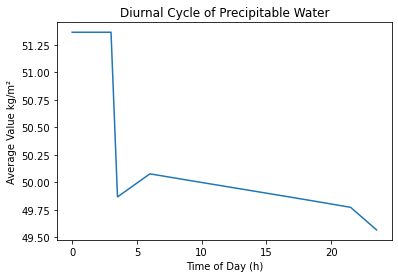

In [63]:
# Create an array representing the time of day (in this case, 48 data points for 24 hours)

time_of_day = np.arange(0, 24, 0.5)

# Plot the diurnal cycle
plt.plot(time_of_day, diurnal_cycle)
plt.xlabel('Time of Day (h)')
plt.ylabel(f'Average Value {var_unit}')
plt.title(f'Diurnal Cycle of {var_name}')

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_diurnal_test1.png')
plt.savefig(save_path)
diurnal_img_path = save_path

plt.show()

### Log Diurnal Plot

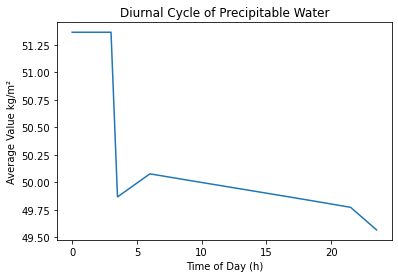

In [64]:
time_of_day = np.arange(0, 24, 0.5)

# Plot the diurnal cycle
plt.plot(time_of_day, diurnal_cycle)
plt.xlabel('Time of Day (h)')
plt.ylabel(f'Average Value {var_unit}')
plt.title(f'Diurnal Cycle of {var_name}')

# Set the y-axis scale to logarithmic
ax.set_yscale('log')

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_diurnalLOG_test1.png')
plt.savefig(save_path)
diurnalLOG_img_path = save_path

plt.show()

# Data vs Convolution vs Diurnal Cycle

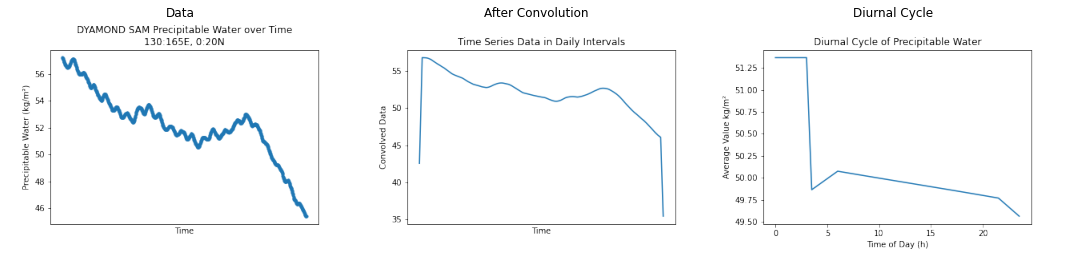

In [65]:
from PIL import Image
# Load the images
image1 = Image.open(data_img_path)
image2 = Image.open(conv_img_path)
image3 = Image.open(diurnal_img_path)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the images on the subplots
axs[0].imshow(image1)
axs[0].axis('off')
axs[0].set_title('Data')

axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title('After Convolution')

axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title('Diurnal Cycle')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### Log Plots

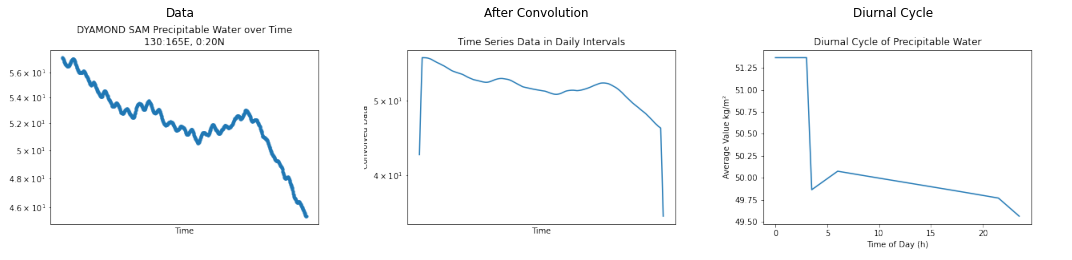

In [66]:
from PIL import Image
# Load the images
image1 = Image.open(dataLOG_img_path)
image2 = Image.open(convLOG_img_path)
image3 = Image.open(diurnalLOG_img_path)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the images on the subplots
axs[0].imshow(image1)
axs[0].axis('off')
axs[0].set_title('Data')

axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title('After Convolution')

axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title('Diurnal Cycle')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### Labeled Plots

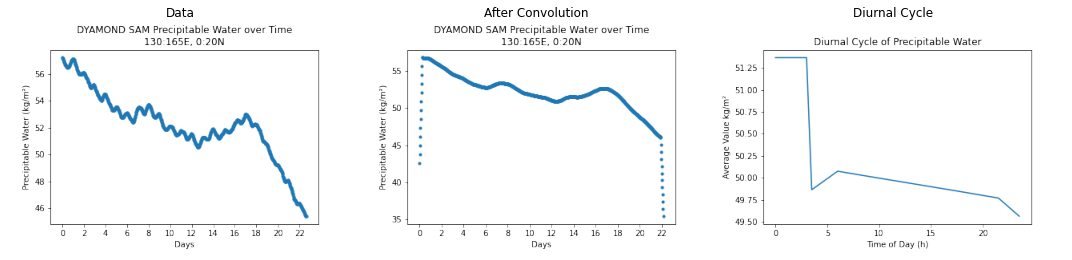

In [67]:
from PIL import Image
# Load the images
image1 = Image.open(dataLABELED_img_path)
image2 = Image.open(convLABELED_img_path)
image3 = Image.open(diurnal_img_path)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the images on the subplots
axs[0].imshow(image1)
axs[0].axis('off')
axs[0].set_title('Data')

axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title('After Convolution')

axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title('Diurnal Cycle')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_LABELED_test1.png')
plt.savefig(save_path)
LABELED_img_path = save_path

# Display the figure
plt.show()

### Labeled Log Plots

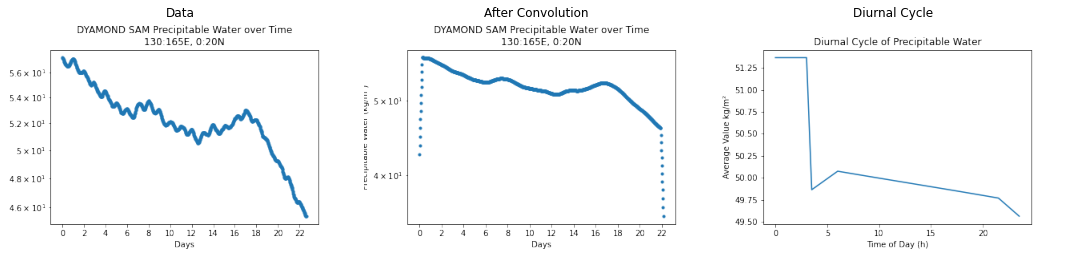

In [68]:
from PIL import Image
# Load the images
image1 = Image.open(dataLABELEDLOG_img_path)
image2 = Image.open(convLABELEDLOG_img_path)
image3 = Image.open(diurnal_img_path)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the images on the subplots
axs[0].imshow(image1)
axs[0].axis('off')
axs[0].set_title('Data')

axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title('After Convolution')

axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title('Diurnal Cycle')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_LABELEDLOG_test1.png')
plt.savefig(save_path)
LABELEDLOG_img_path = save_path

# Display the figure
plt.show()